In [1]:
#TEST IMPORTS
import numpy as np
from ours.V3_3 import Ours_V3_3 
from ours.V4 import Ours_V4
from ours.V4_2 import Ours_V4_2
from ours.V1 import Ours_V1
from cscg.cscg import CHMM, datagen_structured_obs_room

from envs.minigrid import GridWorldEnv
from visualisation_tools import *
import time
import pickle

## MINIGRID SETUP

In [2]:
#TEST MODELS INIT
actions = {'LEFT':0, 'RIGHT':1,'UP':2, 'DOWN':3, 'STAY':4}
env = GridWorldEnv('grid_donut', actions,\
                        max_steps=300, goal=-1)
start_pose = (0,0)
obs,_ = env.reset(start_pose)
ob, pose = obs
start_state_idx = env.get_state(start_pose)

goal = 1
print(env.rooms)


[[ 0  1  2  3  4]
 [ 5 -1 -1 -1 13]
 [ 6 -1 -1 -1 12]
 [ 7  8  9 10  0]]


In [3]:
def agent_B_match_ideal_B_v2(agent_state_mapping, agent_B, perfect_B, desired_state_mapping, actions, tolerance_margin = 0.3):
    """Check if the values == 1 in perfect_B are filled with values relatively close at tolerance level"""
    
    room_valid_state_agent= { k:v for k, v in agent_state_mapping.items() if k in desired_state_mapping.values() }

    if len(room_valid_state_agent) < len(desired_state_mapping):
        return False
    rearranged_B = B_to_ideal_B(agent_B, actions,desired_state_mapping, room_valid_state_agent)
    rearranged_B = rearranged_B[:len(desired_state_mapping),:len(desired_state_mapping),:]
    if rearranged_B.shape != perfect_B.shape:
        raise 'rearranged_B.shape should match B.shape'
    non_zero_mask = perfect_B > 0
    matching_indices = np.where(non_zero_mask & (np.abs(perfect_B - rearranged_B) <= tolerance_margin))
    match_result = np.array_equal(np.array(matching_indices) ,np.array(np.where(non_zero_mask)))
    
    return match_result


In [4]:
len(np.unique(env.rooms))

14

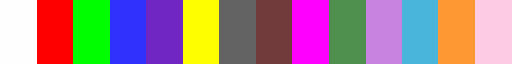

In [5]:
env.rooms_colour_map

<Axes: >

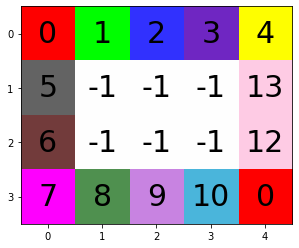

In [6]:
plot_map(env.rooms,env.rooms_colour_map)

## LOAD MODELS

In [7]:
def load_object(load_path):            
    with open(load_path, "rb") as inp:
        agent = pickle.load(inp)
    return agent


In [8]:
from bokeh.plotting import show, output_file, figure
from bokeh.layouts import column, row
from bokeh.models import Div
from bokeh.models.widgets import Panel, Tabs

ModuleNotFoundError: No module named 'bokeh'

In [ ]:
import imageio
def generate_run_report(run_logs, store_path):
    figures = []

    state_beliefs = [log["qs"] for log in run_logs["agent_info"]]

    # Trajectory gif
    gif_path = store_path / "navigate.gif"
    imageio.mimsave(gif_path, run_logs["frames"], 'GIF', duration=500)

    h, w, _ = run_logs["frames"][0].shape
    h = max(128, h)
    w = max(128, w)
    gif = Div(
        text=f"<img src={str(gif_path)} width={w} height={h}></img>",
        width=w,
        height=h,
    )
    figures.append(gif)
    # Entropy plot
    entropies = [entropy(s) for s in state_beliefs]
    fig_entropy = figure(title="Entropy over full state belief", plot_height=200)
    fig_entropy.line(np.arange(len(entropies)), entropies)
    figures.append(fig_entropy)

    # Bayesian Surprise
    surprises = [np.nan_to_num(log["bayesian_surprise"]) for log in run_logs["agent_info"]]
    fig_surprise = figure(title="Bayesian Surprise", plot_height=200)
    fig_surprise.line(np.arange(len(surprises)), surprises)
    figures.append(fig_surprise)

    return row(*figures)

In [ ]:
output_file("report.html")

generate_run_report(data_infos, spath)
#show(layout)

In [ ]:
# from bokeh.models.widgets import Image
from bokeh.io import curdoc

pages = []

spath = get_store_path('cscg', 'test')

spath.mkdir(exist_ok=True, parents=True)


run_logs = {'here':[1,2,3,3,4]}

run_logs['test'] =  ['mia' for _ in run_logs["here"]]

run_logs_df = pd.DataFrame.from_dict(run_logs)

codebook_path = spath / "codebook.png"
n = int(np.ceil(len(run_logs_df['here']) / 10))
w, h = 1000, n *100
# Create an Image widget to display the codebook image
#codebook_img = Div(text=f"<img src='{str(codebook_path)}' width='{w}' height='{h}'>")

codebook = Div(
    text=f"<img src={str(codebook_path)} width={w} height={h}></img>",
    width=w,
    height=h,
)

page = column(
    Div(text=f"{'tutu'}-{'big'}"),
    generate_run_report(data_infos, spath),
    #codebook_img
)
pages.append(
    Panel(child=page, title=f"{'cscg'}: Trial {'1'}")
)

title_path = spath / "cscg_test.html"
output_file(
        title_path,
        title='test_cscg'.capitalize(),
    )

title = Div(text=f"<h1>Report for {'test_cscg'}</h1>")

#curdoc().add_root(column(title, Tabs(tabs=pages)))
show(column(title, codebook, Tabs(tabs=pages)))

run_logs_df.to_csv(spath / f"{'test'}.csv")

## OURS

### colour and pose as ob

In [ ]:
ours_v3_3 = Ours_V3_3(num_obs=2, num_states=2, dim=2, observations=[ob,start_pose], learning_rate_pB=3.0, actions= actions)
#ours_v1 = Ours_V1(num_obs=2, num_states=2, observations=[ob,start_state_idx], learning_rate_pB=3.0, actions= actions)
action_hist = []

In [ ]:
# #RUN oursV3.3 EXPLO
T= 3
import warnings
warnings.filterwarnings('ignore')
perfect_B, desired_state_mapping = env.define_perfect_B()
pose = start_pose
ours_v3_3.explo_oriented_navigation()
data_infos = {'frames':[get_frame(env, pose)], 'agent_info':[]}
policy = [1,1,3,0]
for t in range(0,T):
    print(' __ ')
    print('time', t, 'believed Qs:',ours_v3_3.get_belief_over_states()[0].round(3))
    action, info = ours_v3_3.infer_action()
    #action = policy[t]
    # ours_v3_3.agent.action = np.array([action])
    # ours_v3_3.agent.step_time()
    action_hist.append(action)
    obs, _,_,_ = env.step(action, pose)
    ob, pose = obs
    data = {}
    data_infos['frames'].append(get_frame(env, pose))
    # data_infos['agent_info'].append(info)
    
    next_possible_actions = env.get_next_possible_motions(pose)
    print('action taken:',int(action),'pose:',pose,',ob:', ob)
    ours_v3_3.agent_step_update(action,[ob,pose],next_possible_actions)
    
    # print('after belief update')
    # print('A colours:\n',ours_v3_3.agent.A[0].round(3))
    # print('A poses:\n',ours_v3_3.agent.A[1].round(3))
    # print('B')
    # print_transitions(ours_v3_3.agent.B, actions)
    
    if agent_B_match_ideal_B_v2(ours_v3_3.get_B(), perfect_B, \
                ours_v3_3.get_agent_state_mapping(), \
                desired_state_mapping, actions, tolerance_margin= 0.4):
            print('Transition matrix is good')
            break

### Ours no obs

In [ ]:
from ours.V5 import Ours_V5
ours_v5 = Ours_V5(num_obs=2, num_states=2, dim=1, observations=[start_pose], learning_rate_pB=3.0, actions= actions)
#ours_v1 = Ours_V1(num_obs=2, num_states=2, observations=[ob,start_state_idx], learning_rate_pB=3.0, actions= actions)
action_hist = []

In [ ]:
ours_v5.agent.A[0]

In [ ]:
# #RUN oursV3.3 EXPLO
T= 35
import warnings
warnings.filterwarnings('ignore')
perfect_B, desired_state_mapping = env.define_perfect_B()
pose = start_pose
ours_v5.explo_oriented_navigation()
data_infos = {'frames':[get_frame(env, pose)], 'agent_info':[]}
policy = [1,1,3,0]
next_possible_actions = env.get_next_possible_motions(pose)
for t in range(0,T):
    print(' __ ')
    print('time', t, 'believed Qs:',ours_v5.get_belief_over_states()[0].round(3))
    action, info = ours_v5.infer_action(next_possible_actions=next_possible_actions)
    #action = policy[t]
    # ours_v5.agent.action = np.array([action])
    # ours_v5.agent.step_time()
    action_hist.append(action)
    obs, _,_,_ = env.step(action, pose)
    ob, pose = obs
    data = {}
    data_infos['frames'].append(get_frame(env, pose))
    # data_infos['agent_info'].append(info)
    
    next_possible_actions = env.get_next_possible_motions(pose)
    print('action taken:',int(action),'pose:',pose,',ob:', ob)
    ours_v5.agent_step_update(action,[pose],next_possible_actions)
    
    # print('after belief update')
    # print('A colours:\n',ours_v3_3.agent.A[0].round(3))
    # print('A poses:\n',ours_v3_3.agent.A[1].round(3))
    # print('B')
    # print_transitions(ours_v3_3.agent.B, actions)
    
    if agent_B_match_ideal_B_v2(ours_v5.get_B(), perfect_B, \
                ours_v5.get_agent_state_mapping(), \
                desired_state_mapping, actions, tolerance_margin= 0.4):
            print('Transition matrix is good')
            break

### colour as ob, pose inferred

In [ ]:
def from_int_to_str(policy):
    str_policy = []
    for i, a in enumerate(policy):
        if int(a[0]) == 0:
            a = 'L'
        elif int(a[0]) == 1:
            a = 'R'
        elif int(a[0]) == 2:
            a = 'U'
        elif int(a[0]) == 3:
            a = 'D'
        elif int(a[0]) == 4:
            a = '4'
        str_policy.append(a)
    return str_policy

In [ ]:
del ours_v3_3
import gc
gc.collect()

In [ ]:
# #RUN oursV3.3 EXPLO
ours_v3_3 = Ours_V3_3(num_obs=2, num_states=2, dim=2, \
                      observations=[ob], learning_rate_pB=3.0, actions= actions)
#ours_v1 = Ours_V1(num_obs=2, num_states=2, observations=[ob,start_state_idx], learning_rate_pB=3.0, actions= actions)
ours_v3_3.agent.inference_horizon = 4


# action_hist = []
start_pose = (0,0)
obs,_ = env.reset(start_pose)
ob, pose = obs
T= 3
# import warnings
# warnings.filterwarnings('ignore')
perfect_B, desired_state_mapping = env.define_perfect_B()
ours_v3_3.explo_oriented_navigation()

#data_infos = {'frames':[get_frame(env, pose)], 'agent_info':[]}
#policy = [1,1,3,0]
# print(hypo_qs)
next_possible_actions = env.get_next_possible_motions(pose, no_stay=False)
action_hist = []

for t in range(0,T):
    print(' __ ')
    # test = select_appropriate_qs(ours_v3_3,ours_v3_3.agent.qs, n_step_past=1)
    print('time', t, 'believed Qs:', ours_v3_3.agent.qs[0].round(3))
    # print('q_pi_hist',len(ours_v3_3.agent.q_pi_hist), ours_v3_3.agent.inference_horizon)
    #action, info = ours_v3_3.infer_action(next_possible_actions=next_possible_actions)
    action, info = ours_v3_3.infer_action()#, next_possible_actions=next_possible_actions)
        
    action_hist.append(action)
    obs, _,_,_ = env.step(action, pose)
    ob, pose = obs
    data = {}
    believed_p = ours_v3_3.infer_pose(action,next_possible_actions)
    #data_infos['frames'].append(get_frame(env, pose))
    # data_infos['agent_info'].append(info)
    
    next_possible_actions = env.get_next_possible_motions(pose, )
    print('action taken:',int(action),'pose:',pose,',ob:', ob)
    ours_v3_3.agent_step_update(action,[ob],next_possible_actions)
    
    if agent_B_match_ideal_B_v2(ours_v3_3.get_agent_state_mapping(), ours_v3_3.get_B(), perfect_B, \
            desired_state_mapping, actions, tolerance_margin= 0.4):
        print('Transition matrix is good')
        break

In [ ]:
# #RUN oursV4 EXPLO
start_pose = (0,0)
obs,_ = env.reset(start_pose)
ob, pose = obs

ours_v4 = Ours_V4_2(num_obs=2, num_states=2, dim=2, inference_algo='VANILLA', \
                      observations=[ob], learning_rate_pB=3.0, actions= actions)


T= 30
import warnings
warnings.filterwarnings('ignore')
perfect_B, desired_state_mapping = env.define_perfect_B()
ours_v4.explo_oriented_navigation('VANILLA')

print('D1', ours_v4.D)
#data_infos = {'frames':[get_frame(env, pose)], 'agent_info':[]}
#policy = [1,1,3,0]
# print(hypo_qs)
next_possible_actions = env.get_next_possible_motions(pose, no_stay=False)
action_hist = []

for t in range(0,T):
    print(' __ ')
    # test = select_appropriate_qs(ours_v3_3,ours_v3_3.agent.qs, n_step_past=1)
    # print('time', t, 'believed Qs:', ours_v4.agent.qs[0].round(3))
    # print('q_pi_hist',len(ours_v3_3.agent.q_pi_hist), ours_v3_3.agent.inference_horizon)
    #action, info = ours_v3_3.infer_action(next_possible_actions=next_possible_actions)
    action, info = ours_v4.infer_action()#, next_possible_actions=next_possible_actions)
    action_hist.append(action)
    obs, _,_,_ = env.step(action, pose)
    ob, pose = obs
    data = {}
    believed_p = ours_v4.infer_pose(action,next_possible_actions)
    #data_infos['frames'].append(get_frame(env, pose))
    # data_infos['agent_info'].append(info)
    next_possible_actions = env.get_next_possible_motions(pose, )
    print('action taken:',int(action),'pose:',pose,',ob:', ob)
    ours_v4.agent_step_update(action,[ob],next_possible_actions)
    print('D2', ours_v4.D)
    if agent_B_match_ideal_B_v2(ours_v4.get_agent_state_mapping(),ours_v4.get_B(), perfect_B, \
            desired_state_mapping, actions, tolerance_margin= 0.4):
        print('Transition matrix is good')
        break

In [ ]:
def create_policies(lookahead:int, actions:dict, current_pose:list=(0,0))-> list:
    ''' Given current pose, and the goals poses
    we want to explore or reach those goals, 
    generate policies going around in a square perimeter. 
    Either just forward (goals), or all around (explore)'''

    goal_poses = define_policies_objectives(current_pose, lookahead)
    policies_lists = []
    #get all the actions leading to the endpoints
    for endpoint in goal_poses:
        action_seq_options = define_policies_to_goal(current_pose, endpoint, actions, lookahead)
        policies_lists.extend(action_seq_options)

    if 'STAY' in actions:
        policies_lists.append(np.array([[actions['STAY']]]*lookahead))

    policies_lists = remove_repetitions(policies_lists)
    return policies_lists

def remove_repetitions(policies):
    unique_policies = {tuple(arr.ravel()) for arr in policies}
    # Convert the set back to a list of arrays
    unique_policies = [np.array(policy).reshape(-1, 1) for policy in unique_policies]
    return unique_policies

def define_policies_objectives(current_pose:list, lookahead:int) ->list:
    """ 
    Full 2D exploration around the agent. 
    All corners of square (dist to agent:lookahead) perimeters around agent set as goal
    """
    goal_poses = []

    goal_poses.append([current_pose[0]+lookahead,  current_pose[1]-lookahead])
    goal_poses.append([current_pose[0]+lookahead,  current_pose[1]+lookahead])
    goal_poses.append([current_pose[0]-lookahead,  current_pose[1]-lookahead])
    goal_poses.append([current_pose[0]-lookahead,  current_pose[1]+lookahead])
    
    return goal_poses

def define_policies_to_goal(start_pose:list, end_pose:list, actions:dict, lookahead:int)->list:
    '''
    Given the current pose and goal pose establish all the sequence of actions 
    leading TOWARD the objective. 
    This code is valid without considering obstacles. If there are, consider
    expanding the area of possible paths.
    '''
    dx,dy = abs(int(start_pose[0] - end_pose[0])), abs(int(start_pose[1] - end_pose[1])) # destination cell

    #If we want to explore, we want a grid path coverage (squared)
    paths = exploration_goal_square(dx, dy)
        
    action_seq_options = []

    for path in paths:
        path = np.array(path)
        if start_pose[0] > end_pose[0]:
            path[:,0]= -path[:,0]
        if start_pose[1] > end_pose[1]:
            path[:,1]= -path[:,1]

        action_seq = []
        for step in range(1, len(path)):
            x_diff, y_diff = path[step][0] - path[step - 1][0], path[step][1] - path[step - 1][1]

            if x_diff > 0:  # Go forward x
                action_seq.append([actions['DOWN']])
            elif x_diff < 0:  # Go backward x
                action_seq.append([actions['UP']])
            elif y_diff > 0:  # Go forward y
                action_seq.append([actions['RIGHT']])
            elif y_diff < 0:  # Go backward y
                action_seq.append([actions['LEFT']])
            
            if 'STAY' in actions:
                # Add a 'STAY' action after each step and append it to action_seq_options
                action_seq_with_stay = action_seq.copy()
                action_seq_with_stay.append([actions['STAY']])
                if len(action_seq_with_stay) < lookahead :
                    action_seq_with_stay.extend([[actions['STAY']]] *(lookahead- len(action_seq_with_stay)))
                action_seq_options.append(np.array(action_seq_with_stay).reshape(len(action_seq_with_stay), 1))
        
        if len(action_seq) < lookahead and 'STAY' in actions:
            action_seq.extend([[actions['STAY']]] *(lookahead- len(action_seq_with_stay)))
        elif 'STAY' not in actions:
            print('Create policies; We might neeed to implement what to do if the policy < policy_len')
        action_seq_options.append(np.array(action_seq).reshape(len(action_seq), 1))

    return action_seq_options

In [ ]:
p_3 = create_policies(lookahead=2, actions= actions)

In [ ]:
for i,p in enumerate(p_3):
    print(i, from_int_to_str(p))

### colour as ob

In [ ]:
n_obs = 9
n_clones = 2
num_states = n_obs * n_clones

ours_v3_3 = Ours_V3_3(num_obs=5, num_states= num_states, dim=1, observations=[ob], learning_rate_pB=3.0, actions= actions,set_stationary_B=True)
#ours_v1 = Ours_V1(num_obs=2, num_states=2, observations=[ob,start_state_idx], learning_rate_pB=3.0, actions= actions)
action_hist = []

In [ ]:
#print(ours_v3_3.agent.A[0])

n_clones = np.ones(n_obs, dtype=np.int64) * n_clones

state_loc = np.hstack(
            (np.array([0], dtype=object),n_clones )
        ).cumsum()
A = np.zeros((n_obs, num_states))
for i in range(n_obs ):
    s, f = state_loc[i : i + 2]
    A[i, s:f] = 1.0
# A = np.eye(ours_v3_3.agent.A[0].shape[0])
ours_v3_3.agent.A[0] = A
if len(ours_v3_3.agent.A) > 1 :
    ours_v3_3.agent.A[1] = np.eye(ours_v3_3.agent.A[1].shape[1])
ours_v3_3.agent.pA = utils.dirichlet_like(A, scale = 1)
B_agent = np.random.rand(num_states, num_states, len(actions)) #create_B_matrix(num_states,len(actions))
B_agent = utils.norm_dist(B_agent)
B_agent = set_stationary(B_agent,actions['STAY'])
ours_v3_3.agent.B[0] = B_agent
ours_v3_3.agent.pB = utils.to_obj_array(B_agent)

In [ ]:
# #RUN oursV3.3 EXPLO
T= 60
import warnings
warnings.filterwarnings('ignore')
perfect_B, desired_state_mapping = env.define_perfect_B()
pose = (0,0)
obs,_ = env.reset(start_pose)
ob, pose = obs
ours_v3_3.explo_oriented_navigation()
real_pose_dict = {pose: ours_v3_3.current_pose}
next_possible_actions = env.get_next_possible_motions(pose)

policy = [3,1,3,0]
c_obs = [ob]
p_obs = [pose]
for t in range(0,T):
    print(' __ ')
    print('time', t, 'believed Qs:',ours_v3_3.get_belief_over_states()[0].round(3))
    action, info = ours_v3_3.infer_action(next_possible_actions=next_possible_actions)
    # action = policy[t]
    # ours_v3_3.agent.action = np.array([action])
    # ours_v3_3.agent.step_time()
    action_hist.append(action)
    obs, _,_,_ = env.step(action, pose)
    ob, pose = obs
    c_obs.append(ob)
    p_obs.append(pose)
    #NEXT POSE
    # model_current_pose = ours_v3_3.infer_pose(action, next_possible_actions)
    real_pose_dict[pose] = ours_v3_3.current_pose
    
    next_possible_actions = env.get_next_possible_motions(pose)
    print('action taken:',int(action),'pose:',pose,',ob:', ob)
    agent_step_update(ours_v3_3, action,[ob],next_possible_actions)
    
    # print('after belief update')
    # print('A colours:\n',ours_v3_3.agent.A[0].round(3))
    # print('A poses:\n',ours_v3_3.agent.A[1].round(3))
    # print('B')
    # print_transitions(ours_v3_3.agent.B, actions)
    
    if agent_B_match_ideal_B_v2(ours_v3_3.get_B(), perfect_B, \
                ours_v3_3.get_agent_state_mapping(), \
                desired_state_mapping, actions, tolerance_margin= 0.4):
            print('Transition matrix is good')
            break

### Ours goal

In [ ]:
with open("figures/ours_test.pkl", "wb") as outp:
    pickle.dump(ours_v3_3, outp, pickle.HIGHEST_PROTOCOL)

In [9]:
def from_int_to_str(policy):
    str_policy = []
    for i, a in enumerate(policy):
        if int(a[0]) == 0:
            a = 'L'
        elif int(a[0]) == 1:
            a = 'R'
        elif int(a[0]) == 2:
            a = 'U'
        elif int(a[0]) == 3:
            a = 'D'
        elif int(a[0]) == 4:
            a = '4'
        str_policy.append(a)
    return str_policy

In [16]:
ours_v3_3 = load_object(\
#"/home/idlab332/workspace/higher_level_nav/results/grid_3x3_alias/ours_exploration/ours_v3/ours_v3_2024-02-08-11-16-13/ours_v3.pkl")
#"/home/idlab332/workspace/higher_level_nav/results/grid_4x4_alias/ours_exploration/ours_v3/ours_v3_2024-02-08-13-52-29/ours_v3.pkl")
#3x3: ours_v3_2024-02-08-11-13-37
"results/grid_donut/ours_exploration/ours_v4_2_MMP/ours_v4_2_MMP_2024-02-27-09-32-43/ours_v4_2_MMP.pkl")
#"results/grid_4x4/ours_exploration/ours_v3/ours_v3_2024-02-08-14-39-57/ours_v3.pkl")

In [17]:
preferred_ob = [4, -1]
ours_v3_3.current_pose = None
ours_v3_3.goal_oriented_navigation(obs = preferred_ob.copy())
u=ours_v3_3.reset()


In [12]:
def print_best_policies(self, possible_first_actions):
    print('possible_first_actions', possible_first_actions)
    if possible_first_actions != None:
        print('here')
        #Removing all policies leading us to uninteresting action.
        policies, q_pi = zip(*[(policy, self.q_pi[p_id]) for p_id, policy \
                                in enumerate(self.policies) if policy[0] in possible_first_actions])
    else:
        policies =  self.policies
        q_pi = self.q_pi
    
    options_with_idx = np.array(list(enumerate(q_pi)))
    same_prob = sorted(options_with_idx, key=lambda x: x[1])[:5]
    # same_prob = options_with_idx[
    #                 abs(options_with_idx[:, 1] - np.amax(options_with_idx[:, 1])) <= 1e-8][:, 0]
    print('3 best policies idx', same_prob)
    for prob in same_prob:
        print('q_pi', q_pi[int(prob[0])])
        print('POLICY:', from_int_to_str(policies[int(prob[0])]))

In [18]:
# # #RUN oursV3.3 GOAL
action_hist = []
start_pose = (3,0)
obs,_ = env.reset(start_pose)
ob, p = obs
T= 4
pose = start_pose
c_ob = [ob]
p_ob = [p]
observation = [ob]
ours_v3_3.linear_policies = True
# if ours_v3_3.current_pose != None:
#     observation.append(ours_v3_3.pose_mapping.index(ours_v3_3.current_pose))
# ours_v3_3.agent.prev_obs.append(tuple(observation))
next_possible_actions = env.get_next_possible_motions(pose, no_stay = False)
for t in range(0,T):
    print(' __ ')
    print('time', t)#, 'believed Qs:',ours_v3_3.get_belief_over_states()[0].round(3))
    
    action, _ = ours_v3_3.infer_action(observation=observation, next_possible_actions=next_possible_actions)
    
    print_best_policies(ours_v3_3, next_possible_actions)
    ours_v3_3.initialise_current_pose(observation)
    ours_v3_3.infer_pose(action,next_possible_actions)
    
    action_hist.append(action)
    obs, _,_,_ = env.step(action, pose)
    # int_pose = ours_v3_3.infer_pose(action, next_possible_actions)
    ob, pose = obs
    c_ob.append(ob)
    p_ob.append(pose)
    observation = [ob]
   
    
    next_possible_actions = env.get_next_possible_motions(pose, no_stay = False)
    # if int_pose!= None:
    #     int_pose = ours_v3_3.pose_mapping.index(int_pose)
    print('action taken:',int(action),'real pose:',pose, 'ob:', ob)
    print('next_possible_actions',next_possible_actions)
    ours_v3_3.agent_step_update(action,observation,next_possible_actions)
    
    if (ob == preferred_ob[0] and action == actions['STAY']) \
        or (preferred_ob[0] == np.all(c_ob[-3:]) and pose == np.all(p_ob[-3:])) :
        print('Goal reached')
        break

 __ 
time 0
infer action: inferred prior state [0.007 0.92  0.016 0.006 0.006 0.004 0.006 0.005 0.005 0.005 0.005 0.005
 0.005 0.005]
infer_policies:policy ['R', 'R', 'R', 'R', 'U', 'U', 'U', 'U'] utility_term -5.207624648092464 expected_obs [array([array([0.05877901, 0.02378019, 0.02374551, 0.02528937, 0.03387632,
              0.01748676, 0.08088867, 0.05814115, 0.44029651, 0.09476588,
              0.0630196 , 0.00694524, 0.038033  , 0.03495278])           ,
       array([0.07421861, 0.0503876 , 0.4376785 , 0.09344125, 0.06237104,
              0.05384609, 0.03868185, 0.0352217 , 0.03684969, 0.02816582,
              0.02659253, 0.02658651, 0.0160127 , 0.0199461 ])           ],
      dtype=object), array([array([0.10146764, 0.01495599, 0.02604092, 0.02645638, 0.0527578 ,
              0.01643795, 0.08971223, 0.02750131, 0.05770963, 0.42506275,
              0.08706057, 0.00364502, 0.03748811, 0.03370368])           ,
       array([0.08513144, 0.02341942, 0.05509146, 0.42488642, 0.08

## More show

In [ ]:
ours_v3_3 = load_object(\
"results/grid_4x4/ours_exploration/ours_v4_2_MMP/ours_v4_2_MMP_2024-02-27-09-23-56/ours_v4_2_MMP.pkl")

In [ ]:
attrs = vars(ours_v3_3)
for k,v in attrs.items():
    print(k,v)
print('_____')
attrs2 = vars(ours_v3_3.agent)
for k,v in attrs2.items():
    print(k,v)

In [ ]:
ours_test= load_object(\
"results/grid_donut/ours_exploration/ours_v4_2_MMP/ours_v4_2_MMP_2024-02-26-18-29-40/ours_v4_2_MMP.pkl")

In [ ]:
attrs = vars(ours_test)
for k,v in attrs.items():
    if k=='A' or k=='B' or k=='qs_hist':
        print(k)
    else:
        print(k,v)
print('_____')
# print(attrs['inference_algo'])
# print(attrs['policies'])
# for k,v in attrs2.items():
#     print(k,v)

In [ ]:
t

In [ ]:
print(action_hist)

In [ ]:
i = print_transitions(ours_v3_3.agent.B[0], actions)

<Axes: >

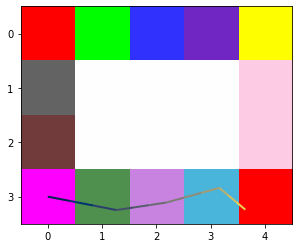

In [19]:
plot_path_in_map(env, start_pose, action_hist[0:])

In [ ]:
ours_v3_3.get_agent_state_mapping()

In [ ]:
plot_transition_detailed(ours_v3_3.get_B(), actions, ours_v3_3.get_agent_state_mapping(), desired_state_mapping, 'ours_v3_3', plot=True, save=False)

In [ ]:

rearranged_B = B_to_ideal_B(agent_B, actions,desired_state_mapping, room_valid_state_agent)
rearranged_B = rearranged_B[:len(desired_state_mapping),:len(desired_state_mapping),:]
c = rearranged_B >= 0.6
non_zero_mask = perfect_B > 0
for i in range(rearranged_B.shape[2]):
    print('action:',i)
    print(c[:,:,i]==non_zero_mask[:,:,i] )
    print(rearranged_B[:,:,i].round(3))
    print()

In [ ]:
a = plot_transition(ours_v3_3.get_B(), actions)

In [ ]:
plot_likelihood(ours_v3_3.get_A()[0], state_mapping=ours_v3_3.get_agent_state_mapping(), tittle_add='colour')

In [ ]:
a = print_transitions(ours_v3_3.get_B(), actions)

In [ ]:
from pathlib import Path
qs_hist = ours_v3_3.agent.qs_hist[:]
max_length = max(len(arr[0]) for arr in qs_hist)
qs_hist = [np.pad(arr[0], (0, max_length - len(arr[0])), mode='constant') for arr in qs_hist]

# prior = qs_hist[-2]
# print(np.array(qs_hist).round(3))
states = np.argmax(qs_hist, axis=1)
v = np.unique(states)
T = ours_v3_3.agent.B[0][:,v,:][v,:]
A = T.sum(2)
div = A.sum(1, keepdims=True)
A /= (div + 0.0001)
A[A < 0.01] = 0
print(A)
#state_map = ours_v3_3.get_agent_state_mapping()
state_map = {pose: {'state':1,'ob':1}}
plot_cscg_graph(A, c_obs, v, n_clones, state_map, Path(''), env.rooms_colour_map)

## CSCG

In [ ]:
def train_cscg(model, observations, actions):
    #len(observations) > len(actions), no matter because this algo considers only actions length 
    if isinstance(observations[0], np.ndarray) or isinstance(observations[0], tuple):
        observations = model.from_obs_to_ob(observations)
    actions = np.array(actions).flatten().astype(np.int64)
    progression = 0
    progression = model.learn_em_T(observations, actions, n_iter=200)  # Training
    # # # refine learning
    model.pseudocount = 0.0001
    model.learn_viterbi_T(observations, actions, n_iter=100)
    return model, progression, observations

In [ ]:
n_emissions = env.rooms.shape[0]* env.rooms.shape[1] #rooms.max() + 1
n_clones = np.ones(n_emissions, dtype=np.int64) * 10
n_actions = max(list(actions.values()))
x = np.array([0])
a = np.array([n_actions])
chmm  =  CHMM(n_clones=n_clones, pseudocount=0.05, possible_actions=actions,\
                x=x, a=a, seed=2, set_stationary_B=True, ob_ambiguity=False) 

In [ ]:
test_model = copy.deepcopy(chmm) 
a_test = []
for steps in range(1000):
    a_test.append(np.random.choice(list(actions.values())))
poses, c_obs = from_policy_to_pose(env, start_pose, a_test, add_rand=False)
poses = [tuple(map(int, sub)) for sub in poses]
obss = np.array([np.array([c, p], dtype=object) for c, p in zip(c_obs, poses)])
agent_state_mapping = test_model.set_agent_state_mapping(obss)

test_model, p, observations = train_cscg(test_model, obss.copy(), a_test)
v = np.unique(test_model.states)
T = test_model.T[:, v][:, :, v]
A_test_model = T.sum(0).round(3)


In [ ]:
perfect_B, desired_state_mapping = env.define_perfect_B()

In [ ]:

def agent_B_match_ideal_B_v2(agent_state_mapping, agent_B, perfect_B, desired_state_mapping, actions, tolerance_margin = 0.3):
    """Check if the values == 1 in perfect_B are filled with values relatively close at tolerance level"""
    
    room_valid_state_agent= { k:v for k, v in agent_state_mapping.items() if k in desired_state_mapping.values() }
    if len(room_valid_state_agent) < len(desired_state_mapping):
        print('too small matrix')
        return False
    rearranged_B = B_to_ideal_B(agent_B, actions,desired_state_mapping, room_valid_state_agent)
    rearranged_B = rearranged_B[:len(desired_state_mapping),:len(desired_state_mapping),:]
    plot_transition(rearranged_B, actions)
    if rearranged_B.shape != perfect_B.shape:
        raise 'rearranged_B.shape should match B.shape'
    non_zero_mask = perfect_B > 0
    matching_indices = np.where(non_zero_mask & (np.abs(perfect_B - rearranged_B) <= tolerance_margin))
    match_result = np.array_equal(np.array(matching_indices) ,np.array(np.where(non_zero_mask)))
    
    return match_result

In [ ]:
def transition_explo_reached(model, perfect_B, desired_state_mapping, actions, tolerance_margin = 0.4, real_pose_dict=None):
    agent_state_mapping = model.get_agent_state_mapping()
    agent_B = model.get_B()
    if real_pose_dict is not None:
        agent_state_mapping = {real_pose_dict[key]: value for key, value in list(agent_state_mapping.items()) if key in real_pose_dict}
    return agent_B_match_ideal_B_v2(agent_state_mapping, agent_B, perfect_B, 
            desired_state_mapping, actions, tolerance_margin= tolerance_margin)


In [ ]:
#CSCG EXPLORATION
T=300
ob = env.get_ob_given_p(start_pose)
c_obs, a = [np.array([ob],dtype=np.int64), np.array([], dtype=np.int64)]
poses = [start_pose]
pose = start_pose
test = []

ok = False
for t in range(0,T):
    next_possible_actions = env.get_next_possible_motions(pose, no_stay=False)
    
    # print('p next actions', pose, next_possible_actions)
    next_possible_actions = [0,1,2,3]
    #print('observations', [ob, pose])
    action, _ = chmm.infer_action(next_possible_actions = next_possible_actions, observation=[ob, pose], random_policy=False)
    # test.append(chmm.pose_mapping.index(pose))
    obs, _,_,_ = env.step(action, pose)
    ob, pose = obs
    c_obs =np.append(c_obs,ob)
    a= np.append(a,action)
    poses.append(pose)

    # test.append(chmm.pose_mapping.index(pose))
    observations = np.array([np.array([c, p], dtype=object) for c, p in zip(c_obs[:len(a)], poses[:len(a)])])
    
    if t % 11 == 0:
        model = copy.deepcopy(chmm)
        model, progression, digested_observations = train_cscg(model, observations, a)
        if isinstance(observations[0], np.ndarray) or isinstance(observations[0], tuple):
            # obs = test_model.from_obs_to_ob(observations)
            observations[:,1] = model.from_pose_to_idx(observations[:,1])
            
        asm = model.get_agent_state_mapping(observations,a,poses[:-1])
        if transition_explo_reached(model, perfect_B, desired_state_mapping, actions, tolerance_margin = 0.4, real_pose_dict=None):
            print('ok')
            ok = True
            break
        del model
if ok != True:
    model = copy.deepcopy(chmm)
    observations = np.array([np.array([c, p], dtype=object) for c, p in zip(c_obs[:], poses[:])])
    model, progression, digested_observations = train_cscg(model, observations, a)

In [ ]:
preferred_ob = [3,9]
c_obs = [9,9,9]
if c_obs[-1] in preferred_ob:
    preferred_ob = c_obs[-1]
if (c_obs[-1] == preferred_ob) :
    print('Goal reached')

if np.array_equal([preferred_ob] * 3,c_obs[-3:]):
    print('Goal reached')


In [ ]:
with open("figures/cscg/cscg_test.pkl", "wb") as outp:
    pickle.dump(chmm, outp, pickle.HIGHEST_PROTOCOL)

In [ ]:
model.get_agent_state_mapping()

In [ ]:
chmm.get_agent_state_mapping()

In [ ]:
def plot_cscg_graph_test(
    A, x, v, n_clones,agent_state_mapping, store_path, cmap=cm.Spectral, vertex_size=30
):
    v_map = [value['state'] for value in agent_state_mapping.values()]
    obs = [value['ob'] for value in agent_state_mapping.values()]
    colors = [cmap(nl)[:3] for nl in obs]
    # if isinstance(x[0], np.ndarray):
        
    if not len(v_map) == len(v) :
        print('states don-t match agent_state_mapping')
        try:

            poses = list(agent_state_mapping.keys())
            obs = []
            for s in v:
                if s in v_map:
                    index = v_map.index(s)
                else:
                    index = bisect.bisect_left(v_map, s) -1
                if index < 0:
                    index =0
                obs.append(agent_state_mapping[poses[index]]['ob'])
            colors = [cmap(nl)[:3] for nl in obs]
            # if isinstance(x[0], np.ndarray):
            #     x = x[:,0]
            # node_labels = np.arange(np.max(x) + 1).repeat(n_clones)[v]
            #colors = [cmap(nl)[:3] for nl in node_labels / node_labels.max()]
        except ValueError:
            print('Value error in plot_cscg_graph')
            node_labels = np.arange(np.min([A.shape[0], len(n_clones)])).repeat(n_clones)[v]        
            colors = [cmap(nl)[:3] for nl in node_labels / node_labels.max()]

    g = igraph.Graph.Adjacency((A > 0).tolist())
    print(A)
    print(type(g))

    out = igraph.plot(
        g,
        store_path / 'connection_graph.png',
        layout=g.layout("kamada_kawai"),
        vertex_color=colors,
        vertex_label=v,
        vertex_size=vertex_size,
        margin=50,
    )

    return out

In [ ]:
states = model.states
v = np.unique(states)
T = model.T[:, v][:, :, v]
# T[-1] = model.T[:, v][:, :, v]
A = T.sum(0)
A = A.round(3)
non_zero_mask = A_test_model > 0
current_n_zero_mask = A >0
if np.array_equal(non_zero_mask,current_n_zero_mask):
    print('ok')

In [ ]:
agent_state_mapping

In [ ]:
print(len(obs))
print(len(observations))
print(len(a))
print(len(poses))

In [ ]:
from pathlib import Path

if len(model.states) == 0:
    print('here')
    # poses_idx = from_pose_to_idx(chmm, poses)
    # obs = np.array(poses_idx).flatten().astype(np.int64)
    # a = np.array(a[1:]).flatten().astype(np.int64)
    # states = chmm.decode(x,a)[1]
else:
    states = model.states
v = np.unique(model.states)
# T = test_model.C[:, v][:, :, v]
# A = T.sum(0)
# div = A.sum(1, keepdims=True)
# A /= (div + 0.0001)
obs = observations.copy()
if isinstance(observations[0], np.ndarray) or isinstance(observations[0], tuple):
    # obs = test_model.from_obs_to_ob(observations)
    obs[:,1] = model.from_pose_to_idx(observations[:,1])

agent_state_mapping = model.get_agent_state_mapping(obs,a,poses)
plot_cscg_graph_test(A,digested_observations,v, model.n_clones, agent_state_mapping , Path(''), env.rooms_colour_map)

In [ ]:
Transition_matrix = model.get_B()
T_plot = plot_transition_detailed_resized(Transition_matrix, actions, agent_state_mapping, desired_state_mapping, plot=False)

In [ ]:
plot_path_in_map(env, start_pose, a[:])

In [ ]:
agent_state_mapping = chmm.get_agent_state_mapping()
agent_state_mapping


In [ ]:
if len(chmm.states) == 0:
    states = chmm.decode(x,a[1:])[1]
else:
    states = chmm.states
    v = np.unique(states)
    T = chmm.C[:, v][:, :, v]
    A = T.sum(0)
    div = A.sum(1, keepdims=True)
    A /= (div + 0.0001)
cwd = Path.cwd()
graph = plot_cscg_graph(A, x, v, chmm.n_clones,  cwd, cmap)

graph


In [ ]:
chmm.get_agent_state_mapping(x,a,poses)

In [ ]:
n_states =  9#chmm.get_n_states()
plot_transition(chmm.get_B(), actions, chmm.get_agent_state_mapping(observations,a,poses), \
                             desired_state_mapping, plot=True)

In [ ]:
tr = print_transitions(chmm.get_B(), actions)

In [ ]:
preferred_ob = [3, -1]
chmm = load_object("results/grid_t_maze_alias/cscg_exploration/cscg_pose_ob_random_policy/cscg_pose_ob_random_policy_2024-02-21-09-07-50/cscg_pose_ob_random_policy.pkl")

chmm.goal_oriented_navigation(obs = [3, -1])

In [ ]:
chmm.get_agent_state_mapping()

In [ ]:
def goal_reached(model, action , c_obs, p_obs, actions):
    if c_obs[-1] in model.preferred_ob:
        preferred_ob = c_obs[-1]
    else:
        preferred_ob = model.preferred_ob[0]
    print('preferred_ob', preferred_ob, c_obs[-1], model.preferred_ob)
    if (c_obs[-1] == preferred_ob and action == actions['STAY']) :
        print('Goal reached')
        return 1
    elif np.array_equal([preferred_ob] * 3,c_obs[-3:]) and np.array_equal([p_obs[-1]]*3 ,p_obs[-3:]):
        print('Goal reached')
        return 2
    return 0

In [ ]:
chmm.preferred_states

In [ ]:
#CSCG GOAL 
# chmm = load_object("figures/cscg/cscg_test.pkl")

chmm.goal_oriented_navigation(obs = preferred_ob.copy())
pose = (3,2)
obs,_ = env.reset(pose)
ob, pose = obs
print('start ob', ob, pose)
c_obs, a = [np.array([ob],dtype=np.int64), np.array([], dtype=np.int64)]
poses = [pose]

T = 6
for t in range(0,T):
    # print()
    print('my t', t)
    next_possible_actions = env.get_next_possible_motions(pose, no_stay=False)
    print('p next actions', pose, next_possible_actions)
    # next_possible_actions = [0,1,2,3,4]
    action, _ = chmm.infer_action(observation=[ob,pose], random_policy=False, next_possible_actions=next_possible_actions)
    print('pose', pose, 'action chosen:', action)
    obs, _,_,_ = env.step(action, pose)
    ob, pose = obs
    c_obs =np.append(c_obs,ob)
    a= np.append(a,action)
    poses.append(pose)

    if 'pose':
        obs = chmm.from_obs_to_ob(np.array([np.array([c, p], dtype=object) for c, p in zip(c_obs, poses)]))
    else:
        obs = x
    if goal_reached(chmm, action , obs, poses, actions) >0:
        break

In [ ]:
plot_path_in_map(env, start_pose, a[:])